In [2]:
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow tensorflow

In [3]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-26 19:30:13.630050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766777413.852559      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766777413.924130      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766777414.458849      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766777414.458886      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766777414.458889      55 computation_placer.cc:177] computation placer alr

# Pre-processing

In [4]:
# Load parquet files
# Make sure to reference download instructions. You have to download the kaggle dataset and upload it, rename it to a data directory. Video guide coming soon
#from: https://drive.google.com/drive/folders/12-1XR8df-rYkwJuMqMgXYQ9dm6EoDx0f?usp=drive_link
#quickstart guide: https://www.youtube.com/watch?v=WPRarAeelAM
#Original source + description: https://advp.niagads.org/downloads
train_df = pd.read_parquet("/kaggle/input/ad-mri/mri_train.parquet")
test_df  = pd.read_parquet("/kaggle/input/ad-mri/mri_test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)

def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

1. label = 2


/tmp/ipykernel_55/226369642.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


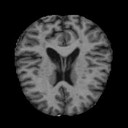

2. label = 0


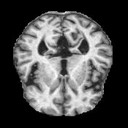

In [5]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)

display_images(train_df, n = 2)

In [6]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X = train_df["image"].values
y = train_df["label"].values

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))

print("\nTrain label distribution:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())

print("\nVal label distribution:")
print(pd.Series(y_val).value_counts(normalize=True).sort_index())

Train size: 4096
Val size: 1024

Train label distribution:
0    0.141357
1    0.009521
2    0.501221
3    0.347900
Name: proportion, dtype: float64

Val label distribution:
0    0.141602
1    0.009766
2    0.500977
3    0.347656
Name: proportion, dtype: float64


In [7]:
def preprocess_images(X):
    X = np.stack(X).astype("float32")   # (N, 128, 128)
    X = X / 255.0                       # normalize
    X = np.expand_dims(X, axis=-1)      # (N, 128, 128, 1)
    return X

X_train = preprocess_images(X_train)
X_val   = preprocess_images(X_val)

X_train.shape, y_train.shape

((4096, 128, 128, 1), (4096,))

In [8]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds
    .shuffle(buffer_size=1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1766777429.822446      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766777429.826287      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
# Add class weights
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{np.int64(0): np.float64(1.768566493955095),
 np.int64(1): np.float64(26.256410256410255),
 np.int64(2): np.float64(0.4987822698490015),
 np.int64(3): np.float64(0.7185964912280701)}

In [26]:
X_test = preprocess_images(test_df["image"].values)
y_test = test_df["label"].values

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

BATCH_SIZE = 32

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

X_test shape: (1280, 128, 128, 1)
y_test shape: (1280,)


# CNN

In [29]:
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [49]:
model = tf.keras.Sequential([
    layers.Input(shape=(128,128,1)), 
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax"),
])

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [51]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.3349 - loss: 1.3513 - val_acc: 0.3525 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.3684 - loss: 1.3298 - val_acc: 0.4053 - val_loss: 1.3651 - learning_rate: 0.0010
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4544 - loss: 1.1937 - val_acc: 0.5566 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5607 - loss: 0.7904 - val_acc: 0.5254 - val_loss: 1.0427 - learning_rate: 0.0010
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6573 - loss: 0.5381 - val_acc: 0.5811 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7128 - loss: 0.4455 - val_acc: 0.7725 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8150 - loss: 0.3087 - val_acc: 0.7949 - val_loss: 0.4832 - learning_rate: 0.0010
Epoch

In [52]:
# Collect all validation predictions
y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=3))

Confusion matrix:
 [[138   0   3   4]
 [  0  10   0   0]
 [  7   0 498   8]
 [  2   0  12 342]]

Classification report:
              precision    recall  f1-score   support

           0      0.939     0.952     0.945       145
           1      1.000     1.000     1.000        10
           2      0.971     0.971     0.971       513
           3      0.966     0.961     0.963       356

    accuracy                          0.965      1024
   macro avg      0.969     0.971     0.970      1024
weighted avg      0.965     0.965     0.965      1024



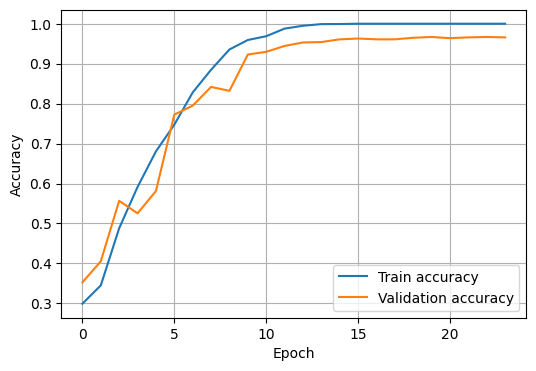

In [61]:
# training vs validation accuracy

plt.figure(figsize=(6,4))

plt.plot(history.history["acc"], label="Train accuracy")
plt.plot(history.history["val_acc"], label="Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.savefig("accuracy_curve.png", dpi=200, bbox_inches="tight")
plt.show()

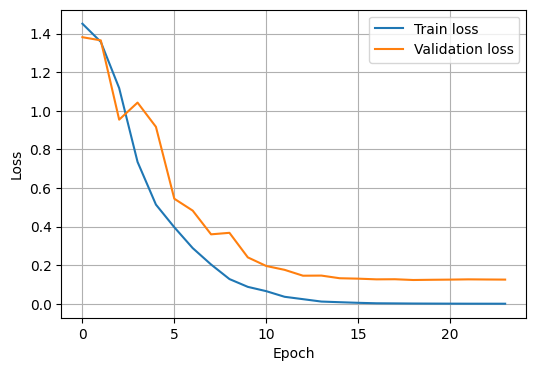

In [62]:
# training vs validation loss

plt.figure(figsize=(6,4))

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.savefig("loss_curve.png", dpi=200, bbox_inches="tight")
plt.show()

In [55]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

40/40 - 0s - 4ms/step - acc: 0.9680 - loss: 0.1315

Test loss: 0.1315
Test accuracy: 0.9680


In [58]:
y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=3))


Confusion matrix:
 [[161   0   3   8]
 [  0  14   0   1]
 [  3   0 622   9]
 [  2   0  15 442]]

Classification report:

              precision    recall  f1-score   support

           0      0.970     0.936     0.953       172
           1      1.000     0.933     0.966        15
           2      0.972     0.981     0.976       634
           3      0.961     0.963     0.962       459

    accuracy                          0.968      1280
   macro avg      0.976     0.953     0.964      1280
weighted avg      0.968     0.968     0.968      1280



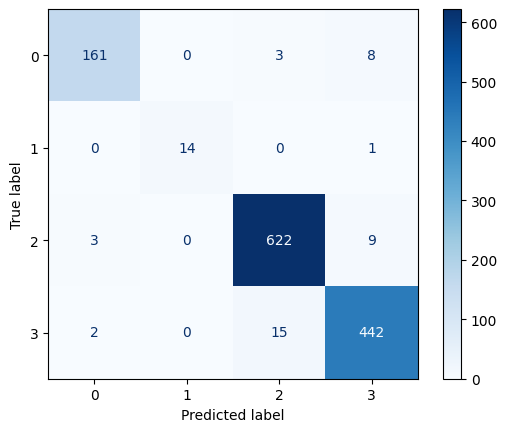

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap="Blues")

plt.savefig("test_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

In [59]:
model.save("AD_mri_cnn_classifier.keras")